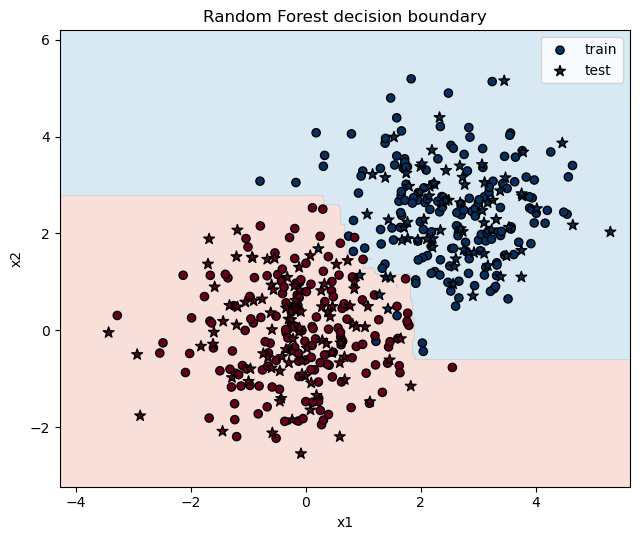

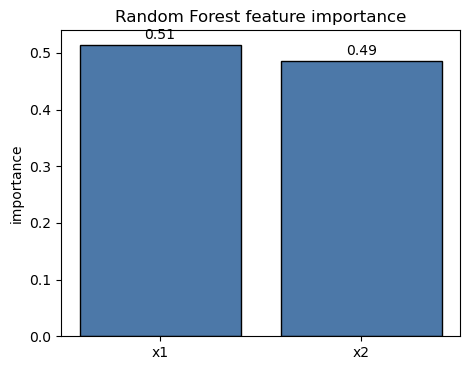

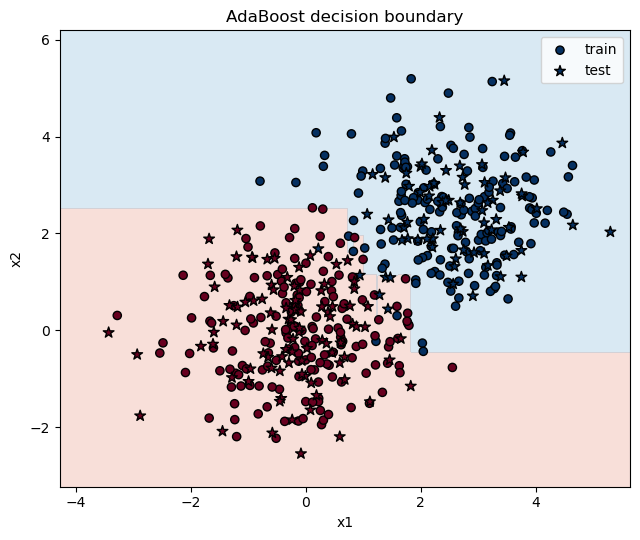

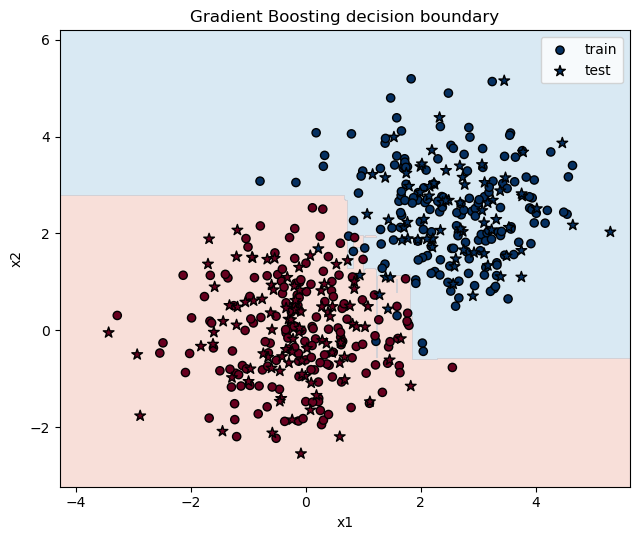

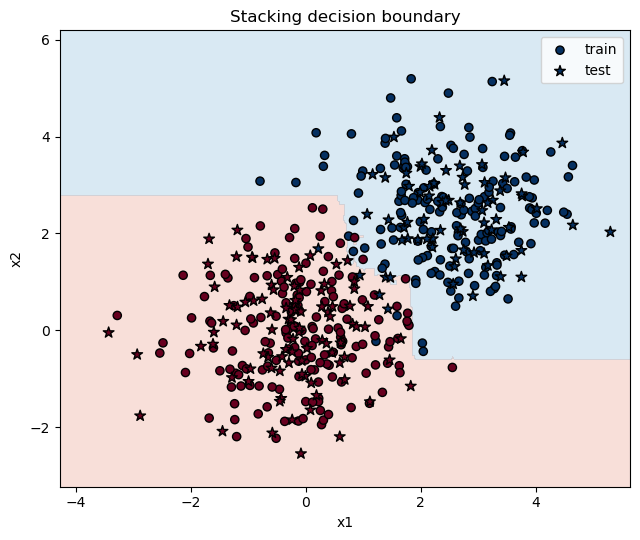

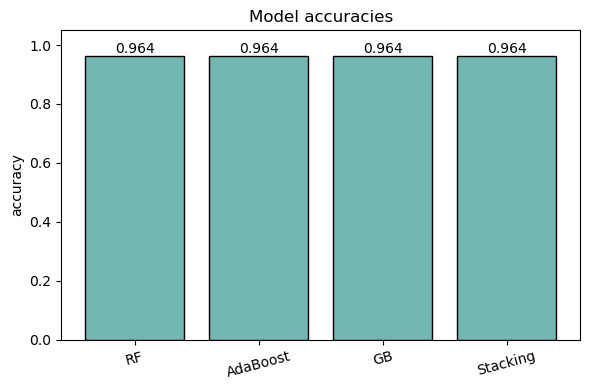

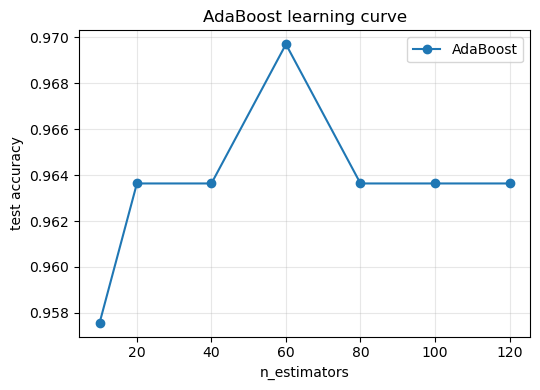

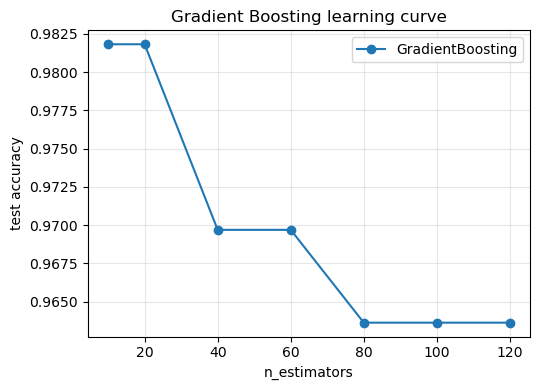

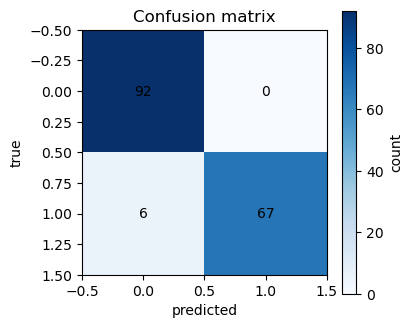

Train acc RF/Ada/GB/Stack: 1.000/1.000/1.000/0.991
Test  acc RF/Ada/GB/Stack: 0.964/0.964/0.964/0.964
Best model on test: RF with accuracy 0.964


In [2]:

import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.bbox"] = "tight"

def make_blobs_binary(n0=200, n1=200, centers=((0,0),(2.5,2.5)), cov=(0.9,0.9), seed=7):
    rng = np.random.default_rng(seed)
    X0 = rng.normal(loc=centers[0], scale=cov[0], size=(n0,2))
    X1 = rng.normal(loc=centers[1], scale=cov[1], size=(n1,2))
    X = np.vstack([X0, X1]).astype(float)
    y = np.concatenate([np.zeros(n0, dtype=int), np.ones(n1, dtype=int)])
    idx = rng.permutation(len(X))
    return X[idx], y[idx]

def train_test_split(X, y, test_size=0.3, seed=42):
    rng = np.random.default_rng(seed)
    n = len(X)
    idx = rng.permutation(n)
    n_test = int(np.floor(test_size * n))
    test_idx, train_idx = idx[:n_test], idx[n_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def gini_impurity_from_counts(counts: np.ndarray) -> float:
    n = counts.sum()
    if n == 0:
        return 0.0
    p = counts / n
    return 1.0 - np.sum(p*p)

def gini_impurity(y: np.ndarray, n_classes: int) -> float:
    return gini_impurity_from_counts(np.bincount(y, minlength=n_classes))

class TreeNode:
    def __init__(self, gini, n_samples, counts, pred_class):
        self.gini = gini
        self.n_samples = n_samples
        self.counts = counts
        self.pred_class = pred_class
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None

class CARTClassifier:
    def __init__(self, max_depth=6, min_samples_split=2, min_impurity_decrease=1e-7, max_features=None, random_state: Optional[int]=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.max_features = max_features  # if None, use all; else integer count
        self.random_state = random_state
        self.n_classes_ = None
        self.n_features_ = None
        self.root_ = None
        self._feat_importances = None
        self._rng = np.random.default_rng(random_state)

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.n_classes_ = int(np.max(y)) + 1
        self.n_features_ = X.shape[1]
        self._feat_importances = np.zeros(self.n_features_)
        self.root_ = self._grow(X, y, 0)
        s = self._feat_importances.sum()
        self.feature_importances_ = self._feat_importances / s if s > 0 else self._feat_importances
        return self

    def _best_split(self, X: np.ndarray, y: np.ndarray):
        m, n = X.shape
        if m < self.min_samples_split:
            return None, None, None
        parent_counts = np.bincount(y, minlength=self.n_classes_)
        parent_gini = gini_impurity_from_counts(parent_counts)

        # choose random subset of features (for RF)
        if self.max_features is None or self.max_features >= n:
            feats = np.arange(n)
        else:
            feats = self._rng.choice(n, size=self.max_features, replace=False)

        best_gain = 0.0
        best_feat = None
        best_thresh = None
        best_left_idx = None

        for feat in feats:
            order = np.argsort(X[:, feat])
            x_sorted = X[order, feat]
            y_sorted = y[order]
            left_counts = np.zeros(self.n_classes_)
            right_counts = parent_counts.astype(float).copy()

            for i in range(1, m):
                c = y_sorted[i-1]
                left_counts[c] += 1
                right_counts[c] -= 1
                if x_sorted[i] == x_sorted[i-1]:
                    continue
                left_n = i
                right_n = m - i
                g_left = gini_impurity_from_counts(left_counts)
                g_right = gini_impurity_from_counts(right_counts)
                weighted = (left_n*g_left + right_n*g_right) / m
                gain = parent_gini - weighted
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat
                    best_thresh = 0.5 * (x_sorted[i] + x_sorted[i-1])
                    best_left_idx = order[:i]

        if best_feat is None or best_gain <= self.min_impurity_decrease:
            return None, None, None
        return best_feat, best_thresh, best_left_idx

    def _grow(self, X: np.ndarray, y: np.ndarray, depth: int) -> TreeNode:
        counts = np.bincount(y, minlength=self.n_classes_)
        node = TreeNode(gini_impurity(y, self.n_classes_), len(y), counts, int(np.argmax(counts)))
        if depth < self.max_depth:
            feat, thr, left_idx = self._best_split(X, y)
            if feat is not None:
                mask_right = np.ones(len(X), dtype=bool)
                mask_right[left_idx] = False
                Xl, yl = X[left_idx], y[left_idx]
                Xr, yr = X[mask_right], y[mask_right]
                # accumulate impurity decrease for feature importances
                weighted = (len(yl)*gini_impurity(yl, self.n_classes_) + len(yr)*gini_impurity(yr, self.n_classes_)) / len(y)
                self._feat_importances[feat] += node.gini - weighted
                node.feature_index = feat
                node.threshold = thr
                node.left = self._grow(Xl, yl, depth+1)
                node.right = self._grow(Xr, yr, depth+1)
        return node

    def predict_row(self, x: np.ndarray) -> int:
        node = self.root_
        while node.left is not None and node.right is not None:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.pred_class

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self.predict_row(x) for x in X], dtype=int)

# --------------------------
# Random Forest (bagging)
# --------------------------
class RandomForestClassifier:
    def __init__(self, n_estimators=50, max_depth=6, min_samples_split=2, max_features=None, bootstrap=True, random_state: Optional[int]=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.trees_ = []
        self._rng = np.random.default_rng(random_state)

    def fit(self, X: np.ndarray, y: np.ndarray):
        n = len(X)
        m_features = self.max_features
        if m_features is None:
            m_features = int(np.ceil(np.sqrt(X.shape[1])))
        self.trees_ = []
        for _ in range(self.n_estimators):
            if self.bootstrap:
                idx = self._rng.integers(0, n, n)
            else:
                idx = self._rng.permutation(n)
            Xb, yb = X[idx], y[idx]
            tree = CARTClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples_split,
                                  max_features=m_features, random_state=int(self._rng.integers(0, 1_000_000)))
            tree.fit(Xb, yb)
            self.trees_.append(tree)
        # Aggregate feature importances
        imps = np.array([t.feature_importances_ for t in self.trees_])
        self.feature_importances_ = imps.mean(axis=0) if len(imps) > 0 else np.zeros(X.shape[1])
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        preds = np.column_stack([t.predict(X) for t in self.trees_])
        # majority vote
        out = np.array([np.bincount(row, minlength=2).argmax() for row in preds], dtype=int)
        return out

class DecisionStump:
    def __init__(self):
        self.feature_index = 0
        self.threshold = 0.0
        self.polarity = 1  # direction

    def fit(self, X: np.ndarray, y_pm1: np.ndarray, sample_weight: np.ndarray):
        m, n = X.shape
        min_error = np.inf
        for feat in range(n):
            order = np.argsort(X[:, feat])
            x_sorted = X[order, feat]
            y_sorted = y_pm1[order]
            w_sorted = sample_weight[order]
            # thresholds between unique values
            for i in range(1, m):
                if x_sorted[i] == x_sorted[i-1]:
                    continue
                thr = 0.5 * (x_sorted[i] + x_sorted[i-1])
                for polarity in (+1, -1):
                    pred = np.where(x_sorted <= thr, polarity, -polarity)
                    err = np.sum(w_sorted * (pred != y_sorted))
                    if err < min_error:
                        min_error = err
                        self.feature_index = feat
                        self.threshold = thr
                        self.polarity = polarity
        return self

    def predict_pm1(self, X: np.ndarray) -> np.ndarray:
        pred = np.where(X[:, self.feature_index] <= self.threshold, self.polarity, -self.polarity)
        return pred

class AdaBoostClassifier:
    def __init__(self, n_estimators=100, learning_rate=1.0, random_state: Optional[int]=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.stumps_ = []
        self.alphas_ = []

    def fit(self, X: np.ndarray, y: np.ndarray):
        # y in {0,1} -> {-1,+1}
        y_pm1 = 2*y - 1
        m = len(X)
        w = np.ones(m) / m
        self.stumps_, self.alphas_ = [], []
        for _ in range(self.n_estimators):
            stump = DecisionStump().fit(X, y_pm1, w)
            pred = stump.predict_pm1(X)
            err = np.sum(w * (pred != y_pm1))
            err = np.clip(err, 1e-12, 1 - 1e-12)
            alpha = 0.5 * np.log((1 - err) / err) * self.learning_rate
            w *= np.exp(-alpha * y_pm1 * pred)
            w /= w.sum()
            self.stumps_.append(stump)
            self.alphas_.append(alpha)
        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        F = np.zeros(len(X))
        for stump, alpha in zip(self.stumps_, self.alphas_):
            F += alpha * stump.predict_pm1(X)
        return F

    def predict(self, X: np.ndarray) -> np.ndarray:
        F = self.decision_function(X)
        return (F >= 0).astype(int)

# --------------------------
# Regression tree (for boosting), squared error
# --------------------------
class RegTreeNode:
    def __init__(self, value: float):
        self.value = value
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None

class RegressionTree:
    def __init__(self, max_depth=2, min_samples_split=2, random_state: Optional[int]=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root_ = None
        self._rng = np.random.default_rng(random_state)

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.root_ = self._grow(X, y, 0)
        return self

    def _best_split(self, X: np.ndarray, y: np.ndarray):
        m, n = X.shape
        if m < self.min_samples_split:
            return None, None, None
        best_sse = np.inf
        best_feat = None
        best_thr = None
        best_left_idx = None
        for feat in range(n):
            order = np.argsort(X[:, feat])
            xs = X[order, feat]
            ys = y[order]
            for i in range(1, m):
                if xs[i] == xs[i-1]:
                    continue
                thr = 0.5*(xs[i] + xs[i-1])
                yl = ys[:i]; yr = ys[i:]
                sse = ((yl - yl.mean())**2).sum() + ((yr - yr.mean())**2).sum()
                if sse < best_sse:
                    best_sse = sse
                    best_feat = feat
                    best_thr = thr
                    best_left_idx = order[:i]
        return best_feat, best_thr, best_left_idx

    def _grow(self, X: np.ndarray, y: np.ndarray, depth: int) -> RegTreeNode:
        node = RegTreeNode(float(y.mean()))
        if depth < self.max_depth:
            feat, thr, left_idx = self._best_split(X, y)
            if feat is not None:
                mask_right = np.ones(len(X), dtype=bool)
                mask_right[left_idx] = False
                Xl, yl = X[left_idx], y[left_idx]
                Xr, yr = X[mask_right], y[mask_right]
                node.feature_index = feat
                node.threshold = thr
                node.left = self._grow(Xl, yl, depth+1)
                node.right = self._grow(Xr, yr, depth+1)
        return node

    def predict(self, X: np.ndarray) -> np.ndarray:
        def pred_row(x, node: RegTreeNode):
            while node.feature_index is not None:
                if x[node.feature_index] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            return node.value
        return np.array([pred_row(x, self.root_) for x in X], dtype=float)

# --------------------------
# Gradient Boosting (binary logistic loss)
# --------------------------
class GradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=2, random_state: Optional[int]=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees_ = []
        self.init_ = 0.0  # initial log-odds

    @staticmethod
    def _sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X: np.ndarray, y: np.ndarray):
        # y in {0,1}
        # Initialize with log-odds
        pos = np.clip(y.mean(), 1e-6, 1-1e-6)
        self.init_ = np.log(pos / (1 - pos))
        F = np.full(len(X), self.init_, dtype=float)
        self.trees_ = []
        rng = np.random.default_rng(self.random_state)

        for m in range(self.n_estimators):
            p = self._sigmoid(F)
            r = y - p  # negative gradient of logistic loss
            # Fit regression tree to residuals
            tree = RegressionTree(max_depth=self.max_depth, random_state=int(rng.integers(0, 1_000_000))).fit(X, r)
            # Newton step: gamma_j = sum r_i / sum p_i(1-p_i) per leaf
            leaf_pred = tree.predict(X)
            # To compute per-leaf gamma, group by identical leaf outputs (tree leaves return a constant)
            unique_vals = np.unique(leaf_pred)
            gamma = {}
            for v in unique_vals:
                idx = (leaf_pred == v)
                denom = np.sum(p[idx]*(1-p[idx])) + 1e-12
                gamma[v] = np.sum(r[idx]) / denom
            # Update F with leaf-specific gamma
            update = np.array([gamma[v] for v in leaf_pred])
            F += self.learning_rate * update
            self.trees_.append((tree, gamma))
        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        F = np.full(len(X), self.init_, dtype=float)
        for tree, gamma in self.trees_:
            leaf_pred = tree.predict(X)
            F += self.learning_rate * np.array([gamma[v] for v in leaf_pred])
        return F

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        F = self.decision_function(X)
        p = 1.0 / (1.0 + np.exp(-F))
        return np.column_stack([1-p, p])

    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.predict_proba(X)[:,1] >= 0.5).astype(int)


# Stacking:(logistic regression) on base predictions

class LogisticRegressionGD:
    def __init__(self, lr=0.1, n_iter=2000, reg=0.0, random_state: Optional[int]=42):
        self.lr = lr
        self.n_iter = n_iter
        self.reg = reg
        self.random_state = random_state
        self.w = None
        self.b = 0.0

    @staticmethod
    def _sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X: np.ndarray, y: np.ndarray):
        rng = np.random.default_rng(self.random_state)
        n, d = X.shape
        self.w = rng.normal(scale=0.01, size=d)
        self.b = 0.0
        for _ in range(self.n_iter):
            z = X @ self.w + self.b
            p = self._sigmoid(z)
            grad_w = (X.T @ (p - y)) / n + self.reg * self.w
            grad_b = np.mean(p - y)
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        z = X @ self.w + self.b
        p = self._sigmoid(z)
        return (p >= 0.5).astype(int)

class StackingClassifier:
    def __init__(self, base_learners: List, meta_learner: LogisticRegressionGD, holdout=0.2, random_state: Optional[int]=42):
        self.base_learners = base_learners
        self.meta_learner = meta_learner
        self.holdout = holdout
        self.random_state = random_state
        self._fitted_bases = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        # split a holdout set from training to create meta-features
        rng = np.random.default_rng(self.random_state)
        n = len(X); h = int(np.floor(self.holdout * n))
        idx = rng.permutation(n)
        H, T = idx[:h], idx[h:]
        Xh, yh = X[H], y[H]
        Xt, yt = X[T], y[T]

        self._fitted_bases = []
        Zt = []
        for learner in self.base_learners:
            model = learner
            model.fit(Xt, yt)
            self._fitted_bases.append(model)
            # meta feature = class probability of positive or decision score
            if hasattr(model, "predict_proba"):
                Zt.append(model.predict_proba(Xh)[:,1])
            elif hasattr(model, "decision_function"):
                # scale to [0,1]
                s = model.decision_function(Xh)
                s = (s - s.min()) / (s.max() - s.min() + 1e-12)
                Zt.append(s)
            else:
                Zt.append(model.predict(Xh))
        Zt = np.column_stack(Zt)
        self.meta_learner.fit(Zt, yh)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        Z = []
        for model in self._fitted_bases:
            if hasattr(model, "predict_proba"):
                Z.append(model.predict_proba(X)[:,1])
            elif hasattr(model, "decision_function"):
                s = model.decision_function(X)
                s = (s - s.min()) / (s.max() - s.min() + 1e-12)
                Z.append(s)
            else:
                Z.append(model.predict(X))
        Z = np.column_stack(Z)
        return self.meta_learner.predict(Z)


# Metrics and plotting

def accuracy(y_true, y_pred): return (y_true == y_pred).mean()

def confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray):
    M = np.zeros((2,2), dtype=int)
    for t, p in zip(y_true, y_pred):
        M[t, p] += 1
    return M

def plot_confusion(M, fname):
    plt.figure(figsize=(4.2,3.6))
    plt.imshow(M, cmap="Blues")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(M[i,j]), ha="center", va="center")
    plt.xlabel("predicted"); plt.ylabel("true")
    plt.title("Confusion matrix")
    plt.colorbar(label="count")
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()

def plot_decision_boundary(model, X, y, title, fname, X_test=None, y_test=None):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)
    plt.figure(figsize=(6.5,5.5))
    plt.contourf(xx, yy, Z, levels=[-0.5,0.5,1.5], cmap="RdBu", alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, cmap="RdBu", edgecolor="k", s=35, label="train")
    if X_test is not None:
        plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap="RdBu", marker="*", s=65, edgecolor="k", label="test")
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.legend()
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()

def plot_feature_importance(importances, fname):
    plt.figure(figsize=(4.8,3.8))
    xs = np.arange(len(importances))
    plt.bar(xs, importances, color="#4C78A8", edgecolor="k")
    plt.xticks(xs, [f"x{i+1}" for i in xs])
    for i, v in enumerate(importances):
        plt.text(i, v+0.01, f"{v:.2f}", ha="center")
    plt.ylabel("importance")
    plt.title("Random Forest feature importance")
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()

def plot_learning_curve(xs, ys, label, title, fname):
    plt.figure(figsize=(5.5,4))
    plt.plot(xs, ys, marker="o", label=label)
    plt.xlabel("n_estimators")
    plt.ylabel("test accuracy")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()

def plot_accuracy_bars(names, vals, fname):
    plt.figure(figsize=(6,4))
    xs = np.arange(len(names))
    plt.bar(xs, vals, color="#72B7B2", edgecolor="k")
    plt.xticks(xs, names, rotation=15)
    for x, v in zip(xs, vals):
        plt.text(x, v+0.01, f"{v:.3f}", ha="center")
    plt.ylim(0, 1.05)
    plt.ylabel("accuracy")
    plt.title("Model accuracies")
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()


# End-to-end demo

def run_demo(random_state=42):
    # Data
    X, y = make_blobs_binary(n0=260, n1=240, centers=((0,0),(2.5,2.5)), cov=(1.0,1.0), seed=10)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33, seed=random_state)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=80, max_depth=6, max_features=1, random_state=random_state).fit(Xtr, ytr)
    prf_tr, prf_te = rf.predict(Xtr), rf.predict(Xte)
    arft, arfe = accuracy(ytr, prf_tr), accuracy(yte, prf_te)

    # AdaBoost
    adb = AdaBoostClassifier(n_estimators=120, learning_rate=0.8, random_state=random_state).fit(Xtr, ytr)
    padb_tr, padb_te = adb.predict(Xtr), adb.predict(Xte)
    aadt, aade = accuracy(ytr, padb_tr), accuracy(yte, padb_te)

    # Gradient Boosting
    gb = GradientBoostingClassifier(n_estimators=120, learning_rate=0.2, max_depth=2, random_state=random_state).fit(Xtr, ytr)
    pgb_tr, pgb_te = gb.predict(Xtr), gb.predict(Xte)
    agbt, agba = accuracy(ytr, pgb_tr), accuracy(yte, pgb_te)

    # Stacking (RF + AdaBoost + GB -> Logistic Regression)
    stk = StackingClassifier(
        base_learners=[
            RandomForestClassifier(n_estimators=60, max_depth=6, max_features=1, random_state=random_state),
            AdaBoostClassifier(n_estimators=80, learning_rate=0.8, random_state=random_state),
            GradientBoostingClassifier(n_estimators=80, learning_rate=0.2, max_depth=2, random_state=random_state)
        ],
        meta_learner=LogisticRegressionGD(lr=0.1, n_iter=2000, reg=1e-3, random_state=random_state),
        holdout=0.2,
        random_state=random_state
    ).fit(Xtr, ytr)
    pstk_tr, pstk_te = stk.predict(Xtr), stk.predict(Xte)
    astt, aste = accuracy(ytr, pstk_tr), accuracy(yte, pstk_te)

    # Visualizations
    plot_decision_boundary(rf, Xtr, ytr, "Random Forest decision boundary", "rf_boundary.png", Xte, yte)
    plot_feature_importance(rf.feature_importances_, "rf_feature_importance.png")
    plot_decision_boundary(adb, Xtr, ytr, "AdaBoost decision boundary", "adb_boundary.png", Xte, yte)
    plot_decision_boundary(gb, Xtr, ytr, "Gradient Boosting decision boundary", "gb_boundary.png", Xte, yte)
    plot_decision_boundary(stk, Xtr, ytr, "Stacking decision boundary", "stacking_boundary.png", Xte, yte)

    names = ["RF", "AdaBoost", "GB", "Stacking"]
    vals = [arfe, aade, agba, aste]
    plot_accuracy_bars(names, vals, "ensemble_accuracies.png")

    # Learning curves for AdaBoost and GB
    est_list = [10, 20, 40, 60, 80, 100, 120]
    adb_accs, gb_accs = [], []
    for ne in est_list:
        AdaBoostClassifier(n_estimators=ne, learning_rate=0.8, random_state=random_state).fit(Xtr, ytr)
        adb_accs.append(accuracy(yte, AdaBoostClassifier(n_estimators=ne, learning_rate=0.8, random_state=random_state).fit(Xtr, ytr).predict(Xte)))
        gb_accs.append(accuracy(yte, GradientBoostingClassifier(n_estimators=ne, learning_rate=0.2, max_depth=2, random_state=random_state).fit(Xtr, ytr).predict(Xte)))
    plot_learning_curve(est_list, adb_accs, "AdaBoost", "AdaBoost learning curve", "adb_learning.png")
    plot_learning_curve(est_list, gb_accs, "GradientBoosting", "Gradient Boosting learning curve", "gb_learning.png")

    # Confusion matrix of best test accuracy
    best_idx = int(np.argmax(vals))
    best_name = names[best_idx]
    best_pred = [prf_te, padb_te, pgb_te, pstk_te][best_idx]
    M = confusion_matrix(yte, best_pred)
    plot_confusion(M, f"{best_name.lower()}_confusion.png")

    print(f"Train acc RF/Ada/GB/Stack: {arft:.3f}/{aadt:.3f}/{agbt:.3f}/{astt:.3f}")
    print(f"Test  acc RF/Ada/GB/Stack: {arfe:.3f}/{aade:.3f}/{agba:.3f}/{aste:.3f}")
    print(f"Best model on test: {best_name} with accuracy {vals[best_idx]:.3f}")

if __name__ == "__main__":
    import sys
    if "ipykernel" in sys.modules:
        run_demo()
    else:
        run_demo()
